# Demo notebook

In [1]:
## imports
import csv
import os

import jax.numpy as jnp
from jax import (grad, jit, vmap, random)
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import seaborn as sns

from code.bhte import (initT_depth_analytic, deltaT_depth_analytic,
                       deltaT_depth_pstd, deltaT_3d_pstd)
from code.constants import (eps_0, mu_0, pi, c)
from code.field import (green, efield, incident_power_density)
from code.utils.dataloader import (load_tissue_diel_properties,
                                   load_antenna_el_properties)
from code.utils.viz import (fig_config, fig_config_reset)

In [2]:
## parameters
# dry skin bhte parameters from IT'IS database
# https://itis.swiss/virtual-population/tissue-properties/database/
k = 0.37       # thermal conductivity [W/m/°C]
rho = 1109.    # dry skin density [kg/m^3]
C = 3391.      # specific heat of dry skin [Ws/kg/°C]
m_b = 1.76e-6  # blood perfusion [m^3/kg/s] in SI units and 106 mL/min/kg in physiology literature units

# for blood
k_b = 0.52     # thermal conductivity [W/m/°C]
rho_b = 1000.  # kg/m^3
C_b = 3617.    # specific heat of blood [J/kg/°C]

# additional parameters
h_0 = 10.      # heat convection coefficient [W/m^2/°C] between the skin surface and the surrounding air
T_a = 37.      # arterial temperature [°C]     
T_c = 37.      # body core temperature [°C]
T_f = 25.      # surrounding air temperature [°C]
Q_m = 33800.   # metabolic heat generation [W/m^3]

## 1-D bioheat transfer equation in time

Comparisson of the spectral method time domain solution and the analytic solution proposed in Foster et al. 2016.\
Initial temperature distribution is obtained via an analytic expression proposed in Deng et al. 2002.

In [3]:
## model input
# frequency
f = 10e9

# conductivity, relative permitivity, tangent loss and penetration depth (Gabriel et al. 1996)
sigma, eps_r, tan_loss, pen_depth = load_tissue_diel_properties('skin_dry', f)

# `pen_depth` is the energy penetration depth into tissue, which is defined as the distance 
# beneath the surface at which the SAR has fallen to a factor of 1/e below that at the surface;
# one-half of the more commonly reported wave penetration depth
pen_depth = pen_depth / 2

# air (vacuum) resistance 
Z_air = np.sqrt(mu_0 / eps_0)

# dry skin resistance
Z_skin_dry = np.sqrt(mu_0 / (eps_r * eps_0))

# energy (Fresnel) transmission coefficient into the tissue
T_tr = 2 * Z_skin_dry / (Z_air + Z_skin_dry)

# I0 T_Tr = 10 W/m^2 at 6 GHz
I0 = 10. / T_tr

In [4]:
## 1-D simulation
# exposure time in seconds
T = 360
t = np.linspace(0, T, 100)

# simulation
N = 101
deltaT = deltaT_depth_pstd(t, N, pen_depth, k, rho, C, m_b * 3, I0, T_tr)

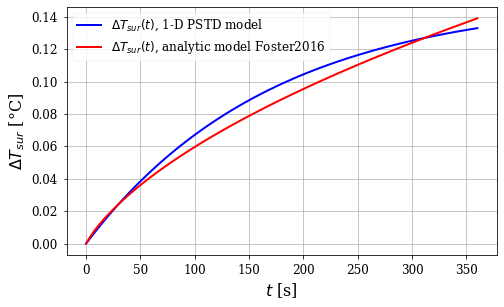

In [5]:
## temperature change on the skin surface after mmWave exposure
fig_config(scaler=1.5)
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(t, deltaT[:, 0], 'b-', linewidth=2, label='$\\Delta T_{sur}(t)$, 1-D PSTD model')
ax.plot(t, deltaT_depth_analytic(t, pen_depth, k, rho, C, I0, T_tr), 'r-', linewidth=2, label='$\\Delta T_{sur}(t)$, analytic model Foster2016')
ax.set_xlabel('$t$ [s]')
ax.set_ylabel('$\\Delta T_{sur}$ [°C]')
ax.legend(loc='upper left')
ax.grid()
plt.tight_layout()
plt.show()

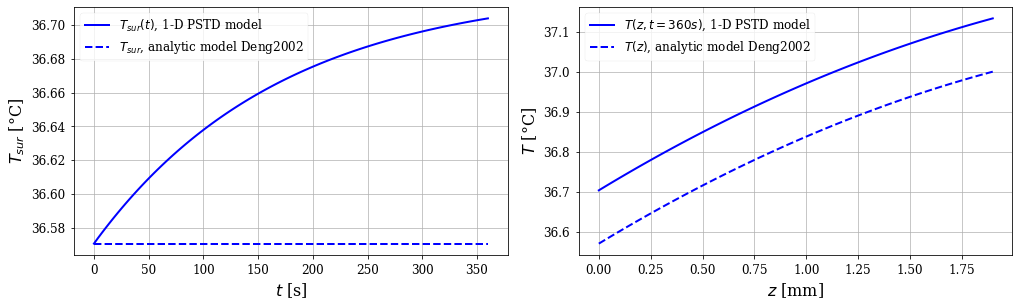

In [6]:
## visualization of the temperature before and after mmWave exposure
dx = pen_depth / N
z = np.linspace(0, pen_depth, N)
T0 = initT_depth_analytic(z, k, rho, C, rho_b, C_b, m_b, h_0, T_a, T_c, T_f, Q_m)
T = T0 + deltaT

fig_config(nrows=1, ncols=2, scaler=1.5)
fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(t, T[:, 0], 'b-', linewidth=2, label='$T_{sur}(t)$, 1-D PSTD model')
ax1.plot(t, np.ones_like(t) * T0[0], 'b--', linewidth=2, label='$T_{sur}$, analytic model Deng2002')
ax1.set_xlabel('$t$ [s]')
ax1.set_ylabel('$T_{sur}$ [°C]')
ax1.legend(loc='upper left')
ax1.grid()

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(z * 1e3, T[-1, :], 'b-', linewidth=2, label=f'$T(z, t={int(t[-1])} s)$, 1-D PSTD model')
ax2.plot(z * 1e3, T0, 'b--', linewidth=2, label='$T(z)$, analytic model Deng2002')
ax2.set_xlabel('$z$ [mm]')
ax2.set_ylabel('$T$ [°C]')
ax2.legend(loc='upper left')
ax2.grid()
plt.tight_layout()
plt.show()

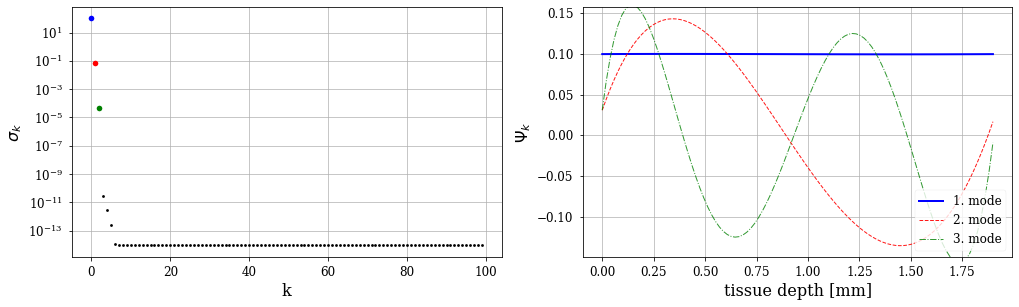

In [7]:
## proper orthogonal decomposition
U, S, VT = np.linalg.svd(deltaT.T)

# the most significant orthogonal modes in the model
fig_config(nrows=1, ncols=2, scaler=1.5)
fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
ax1.semilogy(100 * S / np.sum(S), 'k.')
ax1.semilogy(0, 100 * S[0] / np.sum(S), 'bo')
ax1.semilogy(1, 100 * S[1] / np.sum(S), 'ro')
ax1.semilogy(2, 100 * S[2] / np.sum(S), 'go')
ax1.set_xlabel('k')
ax1.set_ylabel('$\\sigma_k$')
ax1.grid()

colors = ['b', 'r', 'g']
linestyles = ['-', '--', '-.']
linewidths = [2, 1, 1]
alphas = [1, 0.9, 0.8]
ax2 = fig.add_subplot(1, 2, 2)
for idx, (c, ls, lw, alpha) in enumerate(zip(colors, linestyles, linewidths, alphas)):
    ax2.plot(z * 1e3, np.real(U[:, idx]), c=c, linewidth=lw, linestyle=ls, alpha=alpha, label=f'{idx + 1}. mode')
ax2.set_ylim(1.1 * np.min(U[:, 1].real), 1.1 * np.max(U[:, 1].real))
ax2.set_xlabel('tissue depth [mm]')
ax2.set_ylabel('$\\Psi_k$')
ax2.grid()
ax2.legend(loc='lower right')

plt.tight_layout()
plt.show()

## 3-D bioheat transfer equation in time

Comparisson of the spectral method time domain solution and the analytic solution proposed in Foster et al. 2016.
This time, the model for the SMTD method is three-dimensional. Additionally, realistic antenna is considered -- half-wave dipole centrally powered by a voltage source set to 1V.

In [8]:
## model input
# frequency
f = 30e9

# conductivity, relative permitivity, tangent loss and penetration depth (Gabriel et al. 1996)
sigma, eps_r, tan_loss, pen_depth = load_tissue_diel_properties('skin_dry', f)

# `pen_depth` is the energy penetration depth into tissue, which is defined as the distance 
# beneath the surface at which the SAR has fallen to a factor of 1/e below that at the surface;
# one-half of the more commonly reported wave penetration depth
pen_depth = pen_depth / 2

# air (vacuum) resistance 
Z_air = np.sqrt(mu_0 / eps_0)

# dry skin resistance
Z_skin_dry = np.sqrt(mu_0 / (eps_r * eps_0))

# energy (Fresnel) transmission coefficient into the tissue
T_tr = 2 * Z_skin_dry / (Z_air + Z_skin_dry)

# antenna electric properties (Poljak 2005)
antenna_data = load_antenna_el_properties(f)
Is = antenna_data.ireal.to_numpy() + antenna_data.iimag.to_numpy() * 1j

# antenna position -- coordinates
xs = antenna_data.x.to_numpy()
ys = np.zeros_like(xs)
zs = np.zeros_like(xs)

# effective radiated skin area
target_area = (0.02, 0.02)  # 2 x 2 cm2
N = [31] * 3
xt = np.linspace(-target_area[0]/2, target_area[0]/2, N[0]) + xs[-1] / 2
yt = np.linspace(-target_area[1]/2, target_area[1]/2, N[1])
zt = -2 / 1000  # 2 mm distance from the antenna

In [9]:
# absolute electric field distribution over the observed skin area
Etot = np.empty((xt.size, yt.size))
for x_idx, _xt in enumerate(xt):
    for y_idx, _yt in enumerate(yt):
        _zt = zt
        Ex, Ey, Ez = efield(_xt, _yt, _zt, xs, ys, zs, Is, f)
        Etot[x_idx, y_idx] = np.abs(np.sqrt(Ex ** 2 + Ey ** 2 + Ez ** 2))

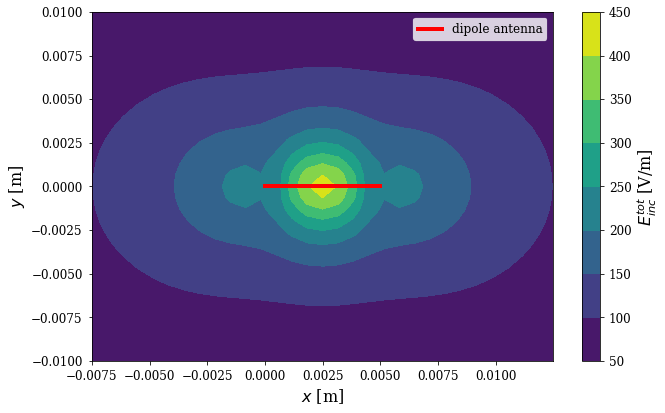

In [10]:
## visualization of the field incident to the skin
mesh = np.meshgrid(xt, yt)

fig_config(nrows=1, ncols=1, scaler=2)
fig = plt.figure()
ax = fig.add_subplot()
cs = ax.contourf(*mesh, Etot.T)
cbar = fig.colorbar(cs, ax=ax)
cbar.ax.set_ylabel('$E_{inc}^{tot}$ [V/m]')
ax.plot(xs, ys, c='r', linewidth=4, label='dipole antenna')
ax.set_xlabel('$x$ [m]')
ax.set_ylabel('$y$ [m]')
ax.legend()
plt.tight_layout()
plt.show()

In [13]:
## 3-D simulation
I0 = incident_power_density(Etot)
SAR_sur = I0 * T_tr / (rho * pen_depth)
sim_time = 860
t = np.linspace(0, sim_time, 11)
T = deltaT_3d_pstd(t, N, target_area, pen_depth, k, rho, C, m_b * 3, SAR_sur)

In [15]:
# np.save(os.path.join('simulations', f'deltaT_Nx{N[0]}Ny{N[1]}Nz{N[2]}_t{sim_time}_a{int(target_area[0]*target_area[1]*1e4)}_dipole.npy'), T, allow_pickle=True, fix_imports=True)

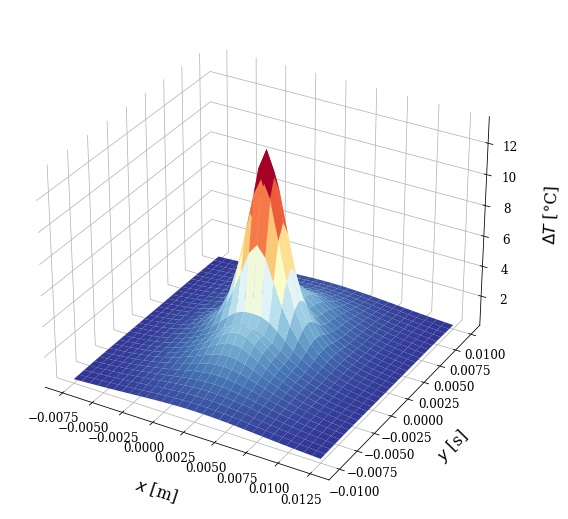

In [16]:
## temperature change distribution on the surface, 3-D plot
fig_config(scaler=2.5)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.xaxis.labelpad = 20
ax.yaxis.labelpad = 20
ax.zaxis.labelpad = 20
ax.w_xaxis.set_pane_color((0, 0, 0))
ax.w_yaxis.set_pane_color((0, 0, 0))
ax.w_zaxis.set_pane_color((0, 0, 0))
# ax.plot_trisurf(xmesh.ravel(), ymesh.ravel(), T[-1, :, :, 0].ravel(), cmap='RdYlBu_r', antialiased=False)
ax.plot_surface(*mesh, T[-1, :, :, 0], cmap='RdYlBu_r', antialiased=True)
ax.set_xlabel('$x$ [m]')
ax.set_ylabel('$y$ [s]')
ax.set_zlabel('$\\Delta T$ [°C]')
plt.tight_layout()
plt.show()

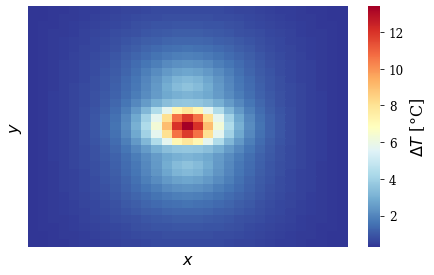

In [17]:
# temperature change distribution on the surface, heatmap
fig_config(scaler=1.5)
fig = plt.figure()
ax = fig.add_subplot(111)
ax = sns.heatmap(T[-1, :, :, 0], cmap='RdYlBu_r', xticklabels=False, yticklabels=False,
                 cbar_kws={'label': '$\\Delta T$ [°C]', 'orientation': 'vertical',})
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
plt.show()

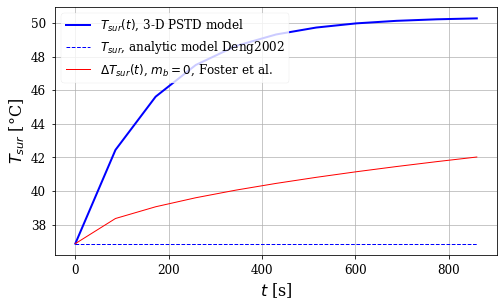

In [20]:
# temperature (depth-wise) before and after mmWave exposure
z = np.linspace(0, pen_depth, N[2])
T0 = initT_depth_analytic(z, k, rho, C, rho_b, C_b, m_b, h_0, T_a, T_c, T_f, Q_m)

fig_config(scaler=1.5)
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(t, np.ones_like(t) * T0[0] + np.max(T[:, :, :, 0], axis=(1, 2)), 'b-', linewidth=2, label='$T_{sur}(t)$, 3-D PSTD model')
ax.plot(t, np.ones_like(t) * T0[0], 'b--', linewidth=1, label='$T_{sur}$, analytic model Deng2002')
ax.plot(t, np.ones_like(t) * T0[0] + deltaT_depth_analytic(t, pen_depth, k, rho, C, np.max(I0), T_tr), 'r-', linewidth=1, label='$\\Delta T_{sur}(t)$, $m_b = 0$, Foster et al.')
ax.set_xlabel('$t$ [s]')
ax.set_ylabel('$T_{sur}$ [°C]')
ax.legend(loc='upper left')
ax.grid()
plt.tight_layout()
plt.show()